In [116]:
import warnings
warnings.filterwarnings('ignore') # Wow nice.

In [183]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras import backend as K

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg') # Non-interactive

import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.model_selection import train_test_split

import numpy as np
from imutils import paths
import cv2
import os

In [153]:
class SmallVGGNet(object):
    @staticmethod
    def build(width, height, num_classes, depth=3): # Depth is 3 cuz' RGB color-space
        model = Sequential()
        input_shape = (height, width, depth)
        chan_dim = -1 # Index of the channel dimension (in order to apply BN)
        
        # First layers set ((Conv => ReLU => BN) * 2 => POOL => DO)
        # 32 filters
        model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(32, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(2, 2))) # Implicit stride of 2x2
        model.add(Dropout(0.25))
        
        # Second layers set ((Conv => ReLU => BN) * 2 => POOL => DO)
        # 64 filters
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # FC layers set (FC => ReLU)
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # Softmax Classifier
        model.add(Dense(num_classes)) # Determined by the number of classes
        model.add(Activation('softmax'))
        
        print(model.summary())
        
        return model

In [154]:
net = SmallVGGNet()
model = net.build(32, 32, 3) # Using 3 classes Dog, Cat and Panda

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_54 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_v1_45 (B (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_55 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_v1_46 (B (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 32)        0         
__________

In [155]:
print('# Loading Animals dataset...')
# trainX = training set datapoints, trainY = training set labels
# Same of testing set
image_paths = list(paths.list_images('animals'))
print('Samples:', image_paths[0: 5])
print('# Animals dataset loaded!')

# Loading Animals dataset...
Samples: ['animals/dogs/dogs_00977.jpg', 'animals/dogs/dogs_00963.jpg', 'animals/dogs/dogs_00793.jpg', 'animals/dogs/dogs_00787.jpg', 'animals/dogs/dogs_00778.jpg']
# Animals dataset loaded!


In [176]:
# Resize images and get labels
images = []
labels = []
for path in image_paths:
    # Looad the image
    image = cv2.imread(path)
    # Resize the image
    image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)
    # Extract a random crop from the image
    image = extract_patches_2d(image, (32, 32), max_patches=1)[0]
    image = img_to_array(image, data_format=None)
    # Append image and its associate label
    images.append(image)
    labels.append(path.split(os.path.sep)[-2])
    
# Num images
print(len(images))

images = np.array(images)
labels = np.array(labels)

3000


In [177]:
# Scale the pixel intensity values to the range [0, 1]
def normalize(images):
    return images.astype('float') / 255.0

images = normalize(images)

In [178]:
# Split the data into training and testing sets 75/25
(trainX, testX, trainY, testY) = train_test_split(images, labels, test_size=0.25, random_state=42)

In [179]:
# Convert the labels from integers to vectors
print('Before converting:', trainY)
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)
print('After converting:', trainY)

Before converting: ['panda' 'dogs' 'cats' ... 'cats' 'cats' 'dogs']
After converting: [[0 0 1]
 [0 1 0]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [0 1 0]]


In [181]:
# Set labels names for easier reading
label_names = ['Dog', 'Cat', 'Panda']

In [184]:
# Handle data augmentation
daug = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

In [187]:
# Define the number of epochs (times dataset has been seen)
num_epochs = 50
# Set the optimizer (here using Stochastic Gradient Descent with a learning rate of 0.01, epochs-based decay and a momentum)
# Decay slowly reduces the learning rate to reduce overfitting and get higher classification accc
sgd_opt = SGD(lr=0.005, decay=0.01 / num_epochs, momentum=0.9, nesterov=True)
# Compile the model
print('# Compiling the model...')
model.compile(loss='categorical_crossentropy', optimizer=sgd_opt, metrics=['accuracy'])
# Train the network!
print('# Training the network...')
M = model.fit_generator(daug.flow(trainX, trainY, batch_size=32), validation_data=(testX, testY),
                        epochs=num_epochs, steps_per_epoch=len(trainX), verbose=1)

# Compiling the model...
# Training the network...
Epoch 1/50
71/71 [==============================] - 13s 189ms/step - loss: 1.3309 - acc: 0.5364 - val_loss: 1.8983 - val_acc: 0.3427
Epoch 2/50
71/71 [==============================] - 13s 179ms/step - loss: 1.0054 - acc: 0.5676 - val_loss: 1.3471 - val_acc: 0.4053
Epoch 3/50
71/71 [==============================] - 13s 179ms/step - loss: 0.9319 - acc: 0.6031 - val_loss: 1.2579 - val_acc: 0.4227
Epoch 4/50
71/71 [==============================] - 13s 181ms/step - loss: 0.8750 - acc: 0.6116 - val_loss: 0.8140 - val_acc: 0.5760
Epoch 5/50
71/71 [==============================] - 13s 183ms/step - loss: 0.8664 - acc: 0.6196 - val_loss: 1.1427 - val_acc: 0.4467
Epoch 6/50
71/71 [==============================] - 13s 185ms/step - loss: 0.8327 - acc: 0.6347 - val_loss: 0.7300 - val_acc: 0.6400
Epoch 7/50
71/71 [==============================] - 13s 185ms/step - loss: 0.8200 - acc: 0.6449 - val_loss: 0.6334 - val_acc: 0.6853
Epoch 8/50
71/71 [

71/71 [==============================] - 13s 185ms/step - loss: 0.5272 - acc: 0.7604 - val_loss: 0.7418 - val_acc: 0.7027
Epoch 39/50
71/71 [==============================] - 13s 185ms/step - loss: 0.5486 - acc: 0.7609 - val_loss: 0.6240 - val_acc: 0.7200
Epoch 40/50
71/71 [==============================] - 13s 187ms/step - loss: 0.5093 - acc: 0.7693 - val_loss: 0.6066 - val_acc: 0.7280
Epoch 41/50
71/71 [==============================] - 13s 185ms/step - loss: 0.5391 - acc: 0.7560 - val_loss: 0.7219 - val_acc: 0.6973
Epoch 42/50
71/71 [==============================] - 13s 185ms/step - loss: 0.5261 - acc: 0.7636 - val_loss: 1.1576 - val_acc: 0.6053
Epoch 43/50
71/71 [==============================] - 13s 188ms/step - loss: 0.5359 - acc: 0.7587 - val_loss: 1.6956 - val_acc: 0.5707
Epoch 44/50
71/71 [==============================] - 13s 186ms/step - loss: 0.5202 - acc: 0.7631 - val_loss: 0.6006 - val_acc: 0.7413
Epoch 45/50
71/71 [==============================] - 14s 191ms/step - loss

# Trained the network! Evaluating...
              precision    recall  f1-score   support

         Dog       0.68      0.64      0.66       249
         Cat       0.62      0.72      0.66       262
       Panda       0.97      0.84      0.90       239

    accuracy                           0.73       750
   macro avg       0.75      0.73      0.74       750
weighted avg       0.75      0.73      0.74       750



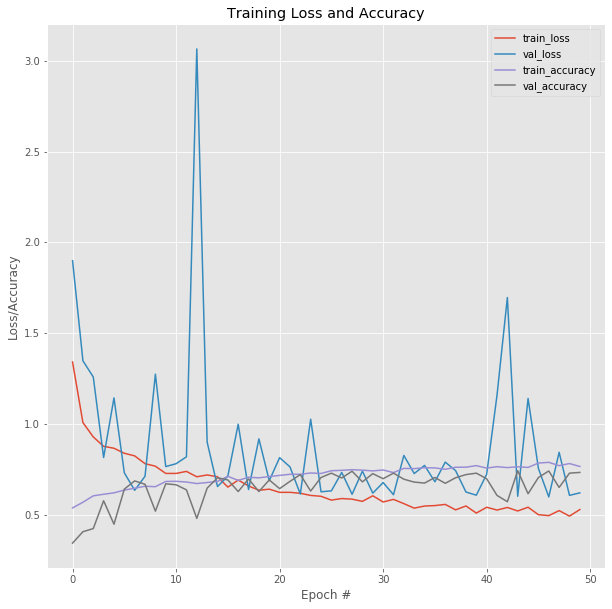

In [213]:
# Evalutate the network
print('# Trained the network! Evaluating...')
preds = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
preds.argmax(axis=1), target_names=label_names))

%matplotlib inline
# Plot history to check for overfitting
plt.style.use('ggplot')
plt.figure(figsize=(10, 10))
plt.plot(np.arange(0, num_epochs), M.history['loss'], label='train_loss')
plt.plot(np.arange(0, num_epochs), M.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, num_epochs), M.history['acc'], label='train_accuracy')
plt.plot(np.arange(0, num_epochs), M.history['val_acc'], label='val_accuracy')

plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend()

plt.show()

In [214]:
# TODO: Tweak net